In [18]:
# Load Libraries & Functions
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats

from src.gen_dataset import gen_dataset
from src.models import gaussian, kde, lowess
from src.helpers.process import convert_ed

from src.helpers.errors import mse, rmse, mae, max_err

## Moepy Testing

In [5]:
# LOWESS weight testing

# Set constants
BINS = 8 # Equi-depth bin count
CYCLES = 1000 # Number of laser cycles
RES = 100000 # Resolution of laser (or # of steps during exposure time)
DEPTH = 2.5 # depth of the scene (in meters)
AMBIENT_STEP = 0.5 # Number of ambient photons added per laser cycle

bds, trs = gen_dataset(bins=BINS, cycles=CYCLES, resolution=RES, scene_depth=DEPTH, ambient_step=AMBIENT_STEP)
proc_bds, proc_trs = convert_ed(bds.copy(), trs.copy(), len(trs), stats.mode(trs))
x_test = np.arange(0, len(trs))

# First Weighting Test
print(proc_bds)
all_weights = []
for i in range(len(proc_bds)):
    dist = np.abs(proc_bds - proc_bds[i])
    frac = 0.1
    frac_idx = int(np.ceil(len(dist)*frac))
    dist_threshold = sorted(dist)[frac_idx]
    dist_to_weights = (1 - ((np.abs(dist)/dist_threshold).clip(0, 1) ** 3)) ** 3
    all_weights += [dist_to_weights]
all_weights = np.array(all_weights)
#print(all_weights)
dist_matrix = np.abs(all_weights.reshape(-1, 1) - all_weights.reshape(1, -1))
#print(dist_matrix)

# Second Weighting Test
frac = 0.1
frac_idx = int(np.ceil(len(proc_bds) * frac)) - 1
print(frac_idx)
dist_matrix = np.abs(proc_bds.reshape(-1, 1) - proc_bds.reshape(1, -1))
print(dist_matrix)
dist_thresholds = np.sort(dist_matrix)[:, frac_idx]
print(dist_thresholds)
weights = (1 - ((np.abs(dist_matrix)/dist_thresholds.reshape(-1, 1).clip(0, 1) ** 3)) ** 3)
print(weights)

[ 7691.5 15818.5 16561.5 17226.  21291.5 37500.  62500.  87500. ]
0
[[    0.   8127.   8870.   9534.5 13600.  29808.5 54808.5 79808.5]
 [ 8127.      0.    743.   1407.5  5473.  21681.5 46681.5 71681.5]
 [ 8870.    743.      0.    664.5  4730.  20938.5 45938.5 70938.5]
 [ 9534.5  1407.5   664.5     0.   4065.5 20274.  45274.  70274. ]
 [13600.   5473.   4730.   4065.5     0.  16208.5 41208.5 66208.5]
 [29808.5 21681.5 20938.5 20274.  16208.5     0.  25000.  50000. ]
 [54808.5 46681.5 45938.5 45274.  41208.5 25000.      0.  25000. ]
 [79808.5 71681.5 70938.5 70274.  66208.5 50000.  25000.      0. ]]
[0. 0. 0. 0. 0. 0. 0. 0.]
[[ nan -inf -inf -inf -inf -inf -inf -inf]
 [-inf  nan -inf -inf -inf -inf -inf -inf]
 [-inf -inf  nan -inf -inf -inf -inf -inf]
 [-inf -inf -inf  nan -inf -inf -inf -inf]
 [-inf -inf -inf -inf  nan -inf -inf -inf]
 [-inf -inf -inf -inf -inf  nan -inf -inf]
 [-inf -inf -inf -inf -inf -inf  nan -inf]
 [-inf -inf -inf -inf -inf -inf -inf  nan]]


/var/folders/f5/btv78drs0kd6sf743ckt2lph0000gn/T/ipykernel_27719/6656196.py:37: RuntimeWarning: divide by zero encountered in divide
  weights = (1 - ((np.abs(dist_matrix)/dist_thresholds.reshape(-1, 1).clip(0, 1) ** 3)) ** 3)
/var/folders/f5/btv78drs0kd6sf743ckt2lph0000gn/T/ipykernel_27719/6656196.py:37: RuntimeWarning: invalid value encountered in divide
  weights = (1 - ((np.abs(dist_matrix)/dist_thresholds.reshape(-1, 1).clip(0, 1) ** 3)) ** 3)


ValueError: x and y must have same first dimension, but have shapes (100000,) and (12,)

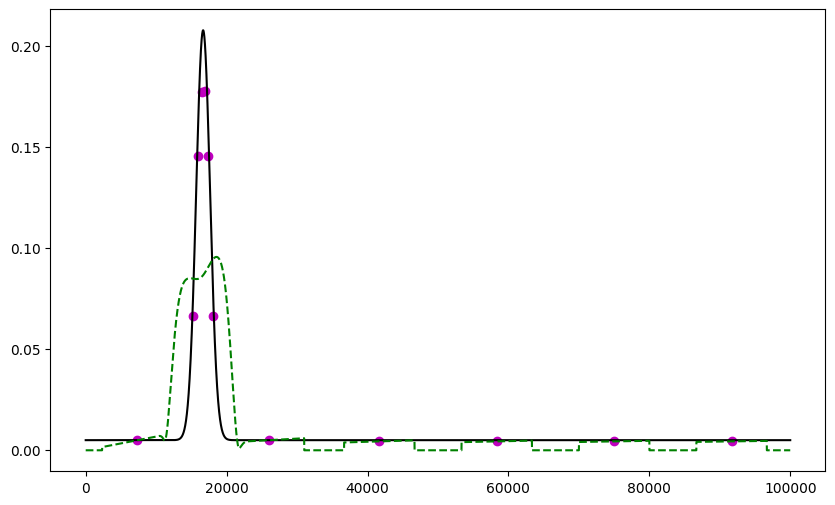

In [13]:
from localreg import *

# Set constants
BINS = 12 # Equi-depth bin count
CYCLES = 1000 # Number of laser cycles
RES = 100000 # Resolution of laser (or # of steps during exposure time)
DEPTH = 2.5 # depth of the scene (in meters)
AMBIENT_STEP = 0.5 # Number of ambient photons added per laser cycle

bds, trs = gen_dataset(bins=BINS, cycles=CYCLES, resolution=RES, scene_depth=DEPTH, ambient_step=AMBIENT_STEP)
proc_bds, proc_trs = convert_ed(bds.copy(), trs.copy(), len(trs), stats.mode(trs))
x_test = np.arange(0, len(trs))

plt.figure(figsize=(10,6))
# ax = plt.gca()
# ax.set_ylim([0, np.max(trs)])
plt.plot(x_test, trs, 'k', label='Ground Truth')
plt.scatter(proc_bds, proc_trs, color='m', label='Estimated Midpoints')

plt.plot(x_test, lowess.regression_fit(proc_bds, proc_trs, x_test), 'g', linestyle='--', label='Lowess')
plt.plot(x_test, localreg(proc_bds, proc_trs), 'r', linestyle='--', label='New Lowess')

plt.legend()
plt.title(f'EDH | Bins: {BINS} | Laser Resolution: {RES} | Cycles: {CYCLES} | Scene Depth: {DEPTH} m')

# Comparisons

Text(0.5, 1.0, 'EDH | Bins: 16 | Laser Resolution: 100000 | Cycles: 1 | Scene Depth: 2.5 m')

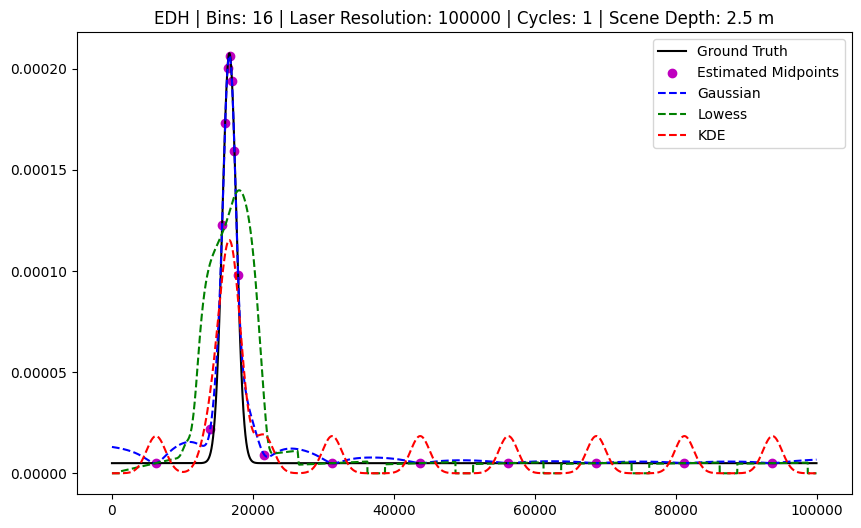

In [16]:
# Set constants
BINS = 16 # Equi-depth bin count
CYCLES = 1 # Number of laser cycles
RES = 100000 # Resolution of laser (or # of steps during exposure time)
DEPTH = 2.5 # depth of the scene (in meters)
AMBIENT_STEP = 0.5 # Number of ambient photons added per laser cycle
T = 100*1e-9 # Laser time period in s
FWHM = 2.317925*1e-9 # Full width half maximum of the laser pulse (Controls the pulse width)

bds, trs = gen_dataset(bins=BINS, cycles=CYCLES, resolution=RES, scene_depth=DEPTH, ambient_step=AMBIENT_STEP, fwhm=FWHM, t=T)
proc_bds, proc_trs = convert_ed(bds.copy(), trs.copy(), len(trs), stats.mode(trs))
x_test = np.arange(0, len(trs))

plt.figure(figsize=(10,6))
# ax = plt.gca()
# ax.set_xlim(bds[1], bds[1]+20000)
# ax.set_ylim([0, np.max(trs)])
plt.plot(x_test, trs, 'k', label='Ground Truth')
plt.scatter(proc_bds, proc_trs, color='m', label='Estimated Midpoints')

plt.plot(x_test, gaussian.regression_fit(proc_bds, proc_trs, x_test), 'b', linestyle='--', label='Gaussian')
plt.plot(x_test, lowess.regression_fit(proc_bds, proc_trs, x_test), 'g', linestyle='--', label='Lowess')
plt.plot(x_test, kde.regression_fit(proc_bds, proc_trs, x_test)*CYCLES, 'r', linestyle='--', label='KDE')

plt.legend()
plt.title(f'EDH | Bins: {BINS} | Laser Resolution: {RES} | Cycles: {CYCLES} | Scene Depth: {DEPTH} m')

# Stats

## Error per bin

/Users/csaldanha/src/python/SPAD_Regression_Research/venv/lib/python3.11/site-packages/moepy/lowess.py:38: RuntimeWarning: divide by zero encountered in divide
  dist_to_weights = lambda dist, dist_threshold=1: (1 - ((np.abs(dist)/dist_threshold).clip(0, 1) ** 3)) ** 3
/Users/csaldanha/src/python/SPAD_Regression_Research/venv/lib/python3.11/site-packages/moepy/lowess.py:38: RuntimeWarning: invalid value encountered in divide
  dist_to_weights = lambda dist, dist_threshold=1: (1 - ((np.abs(dist)/dist_threshold).clip(0, 1) ** 3)) ** 3
/Users/csaldanha/src/python/SPAD_Regression_Research/venv/lib/python3.11/site-packages/moepy/lowess.py:38: RuntimeWarning: divide by zero encountered in divide
  dist_to_weights = lambda dist, dist_threshold=1: (1 - ((np.abs(dist)/dist_threshold).clip(0, 1) ** 3)) ** 3
/Users/csaldanha/src/python/SPAD_Regression_Research/venv/lib/python3.11/site-packages/moepy/lowess.py:38: RuntimeWarning: invalid value encountered in divide
  dist_to_weights = lambda dist,

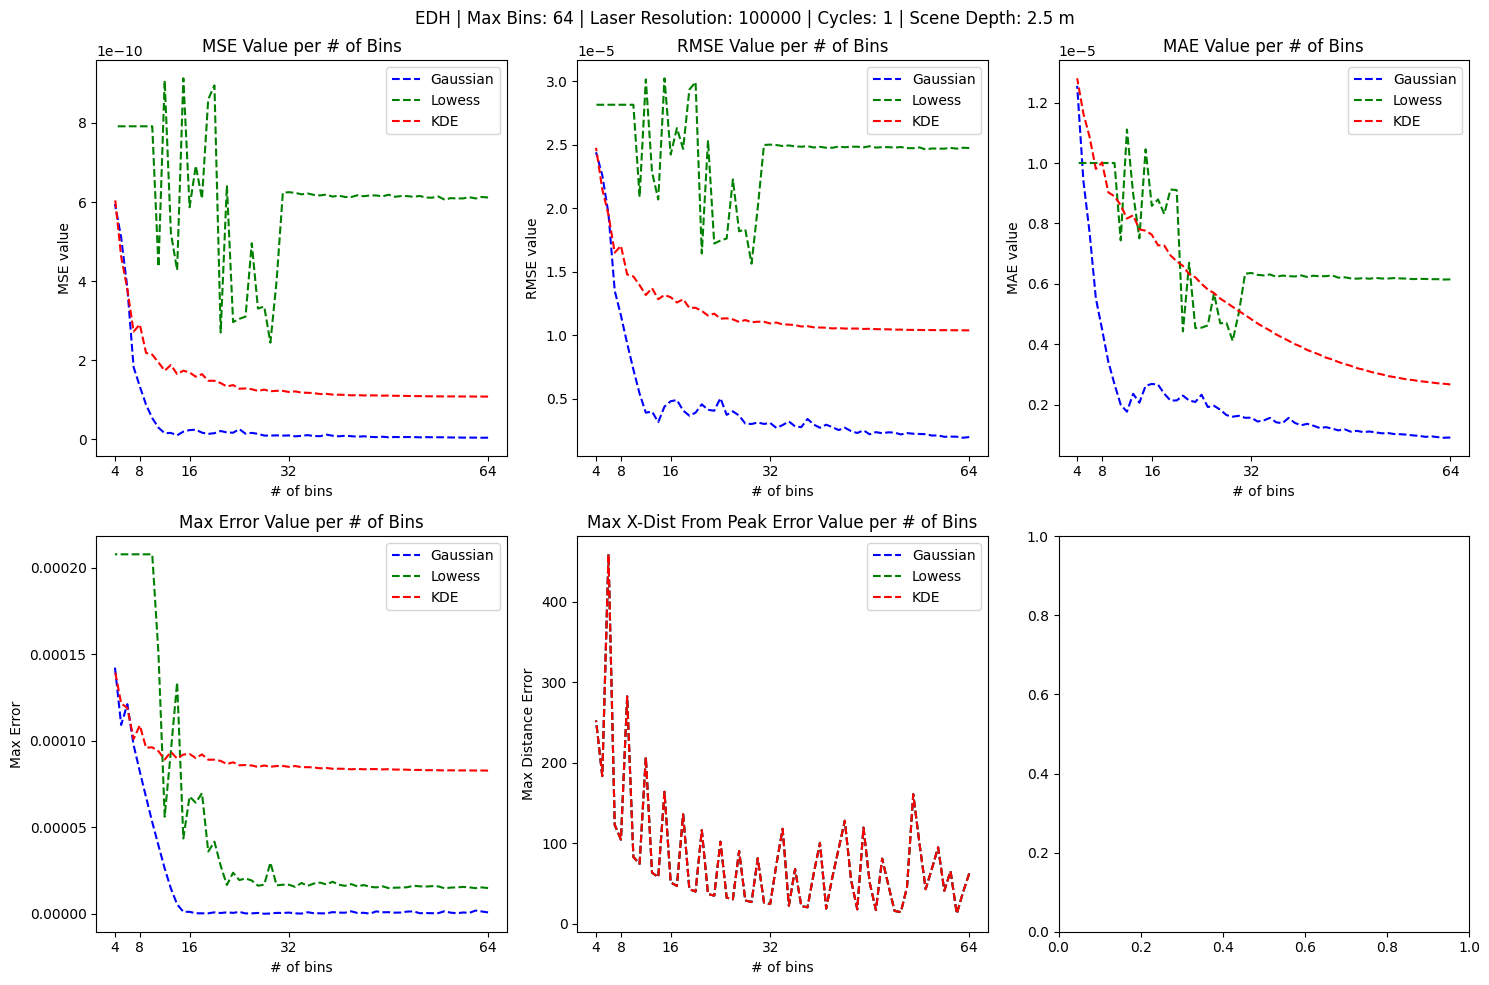

In [17]:
# Set constants
MAX_BINS = 64 # Max equi-depth bin count to test up to
CYCLES = 1 # Number of laser cycles
RES = 100000 # Resolution of laser (or # of steps during exposure time)
DEPTH = 2.5 # depth of the scene (in meters)
AMBIENT_STEP = 0.5 # Number of ambient photons added per laser cycle

def mse_per_bin(x_set, max_bins, model):
    mse_scores = []
    for i in range(4, max_bins+1)[::-1]:
        bounds, trans = gen_dataset(bins=i, cycles=CYCLES, resolution=RES, scene_depth=DEPTH, ambient_step=AMBIENT_STEP)        
        DEFAULT_TR = stats.mode(trans)
        bds, trs = convert_ed(bounds, trans, len(trans), DEFAULT_TR)
        pred_vals = model(bds, trs, x_set)
        mse_scores.append(mse(trans, pred_vals))
    return mse_scores

def rmse_per_bin(x_set, max_bins, model):
    rmse_scores = []
    for i in range(4, max_bins+1)[::-1]:
        bounds, trans = gen_dataset(bins=i, cycles=CYCLES, resolution=RES, scene_depth=DEPTH, ambient_step=AMBIENT_STEP)        
        DEFAULT_TR = stats.mode(trans)
        bds, trs = convert_ed(bounds, trans, len(trans), DEFAULT_TR)
        pred_vals = model(bds, trs, x_set)
        rmse_scores.append(rmse(trans, pred_vals))
    return rmse_scores

def mae_per_bin(x_set, max_bins, model):
    mae_scores = []
    for i in range(4, max_bins+1)[::-1]:
        bounds, trans = gen_dataset(bins=i, cycles=CYCLES, resolution=RES, scene_depth=DEPTH, ambient_step=AMBIENT_STEP)        
        DEFAULT_TR = stats.mode(trans)
        bds, trs = convert_ed(bounds, trans, len(trans), DEFAULT_TR)
        pred_vals = model(bds, trs, x_set)
        mae_scores.append(mae(trans, pred_vals))
    return mae_scores

def max_err_per_bin(x_set, max_bins, model):
    max_err_scores = []
    for i in range(4, max_bins+1)[::-1]:
        bounds, trans = gen_dataset(bins=i, cycles=CYCLES, resolution=RES, scene_depth=DEPTH, ambient_step=AMBIENT_STEP)        
        DEFAULT_TR = stats.mode(trans)
        bds, trs = convert_ed(bounds, trans, len(trans), DEFAULT_TR)
        pred_vals = model(bds, trs, x_set)
        max_err_scores.append(max_err(trans, pred_vals))
    return max_err_scores

def max_dist_err_per_bin(x_set, max_bins, model):
    max_err_scores = []
    for i in range(4, max_bins+1)[::-1]:
        bounds, trans = gen_dataset(bins=i, cycles=CYCLES, resolution=RES, scene_depth=DEPTH, ambient_step=AMBIENT_STEP)        
        DEFAULT_TR = stats.mode(trans)
        bds, trs = convert_ed(bounds, trans, len(trans), DEFAULT_TR)
        max_true_idx = np.where(trans == np.max(trans))[0][0]
        max_pred_idx = np.where(trs == np.max(trs))[0][0]
        max_err_scores.append(mae(x_test[max_true_idx], bds[max_pred_idx]))
    return max_err_scores

# Graph Results
x_test = np.arange(0, RES)
x_plot = np.arange(4, MAX_BINS+1)[::-1]
ticks = np.array([2**x for x in range(7)][2:])

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0][0].plot(x_plot, mse_per_bin(x_test, MAX_BINS, gaussian.regression_fit), 'b', linestyle='--', label='Gaussian')
axes[0][0].plot(x_plot, mse_per_bin(x_test, MAX_BINS, lowess.regression_fit), 'g', linestyle='--', label='Lowess')
axes[0][0].plot(x_plot, mse_per_bin(x_test, MAX_BINS, kde.regression_fit), 'r', linestyle='--', label='KDE')
axes[0][0].set_xticks(ticks, ticks)
axes[0][0].set_xlabel('# of bins')
axes[0][0].set_ylabel('MSE value')
axes[0][0].title.set_text('MSE Value per # of Bins')
axes[0][0].legend()

axes[0][1].plot(x_plot, rmse_per_bin(x_test, MAX_BINS, gaussian.regression_fit), 'b', linestyle='--', label='Gaussian')
axes[0][1].plot(x_plot, rmse_per_bin(x_test, MAX_BINS, lowess.regression_fit), 'g', linestyle='--', label='Lowess')
axes[0][1].plot(x_plot, rmse_per_bin(x_test, MAX_BINS, kde.regression_fit), 'r', linestyle='--', label='KDE')
axes[0][1].set_xticks(ticks, ticks)
axes[0][1].set_xlabel('# of bins')
axes[0][1].set_ylabel('RMSE value')
axes[0][1].title.set_text('RMSE Value per # of Bins')
axes[0][1].legend()

axes[0][2].plot(x_plot, mae_per_bin(x_test, MAX_BINS, gaussian.regression_fit), 'b', linestyle='--', label='Gaussian')
axes[0][2].plot(x_plot, mae_per_bin(x_test, MAX_BINS, lowess.regression_fit), 'g', linestyle='--', label='Lowess')
axes[0][2].plot(x_plot, mae_per_bin(x_test, MAX_BINS, kde.regression_fit), 'r', linestyle='--', label='KDE')
axes[0][2].set_xticks(ticks, ticks)
axes[0][2].set_xlabel('# of bins')
axes[0][2].set_ylabel('MAE value')
axes[0][2].title.set_text('MAE Value per # of Bins')
axes[0][2].legend()

axes[1][0].plot(x_plot, max_err_per_bin(x_test, MAX_BINS, gaussian.regression_fit), 'b', linestyle='--', label='Gaussian')
axes[1][0].plot(x_plot, max_err_per_bin(x_test, MAX_BINS, lowess.regression_fit), 'g', linestyle='--', label='Lowess')
axes[1][0].plot(x_plot, max_err_per_bin(x_test, MAX_BINS, kde.regression_fit), 'r', linestyle='--', label='KDE')
axes[1][0].set_xticks(ticks, ticks)
axes[1][0].set_xlabel('# of bins')
axes[1][0].set_ylabel('Max Error')
axes[1][0].title.set_text('Max Error Value per # of Bins')
axes[1][0].legend()

axes[1][1].plot(x_plot, max_dist_err_per_bin(x_test, MAX_BINS, gaussian.regression_fit), 'b', linestyle='--', label='Gaussian')
axes[1][1].plot(x_plot, max_dist_err_per_bin(x_test, MAX_BINS, lowess.regression_fit), 'g', linestyle='--', label='Lowess')
axes[1][1].plot(x_plot, max_dist_err_per_bin(x_test, MAX_BINS, kde.regression_fit), 'r', linestyle='--', label='KDE')
axes[1][1].set_xticks(ticks, ticks)
axes[1][1].set_xlabel('# of bins')
axes[1][1].set_ylabel('Max Distance Error')
axes[1][1].title.set_text('Max X-Dist From Peak Error Value per # of Bins')
axes[1][1].legend()

fig.suptitle(f'EDH | Max Bins: {MAX_BINS} | Laser Resolution: {RES} | Cycles: {CYCLES} | Scene Depth: {DEPTH} m')
fig.tight_layout()

## Error from realistic transient data

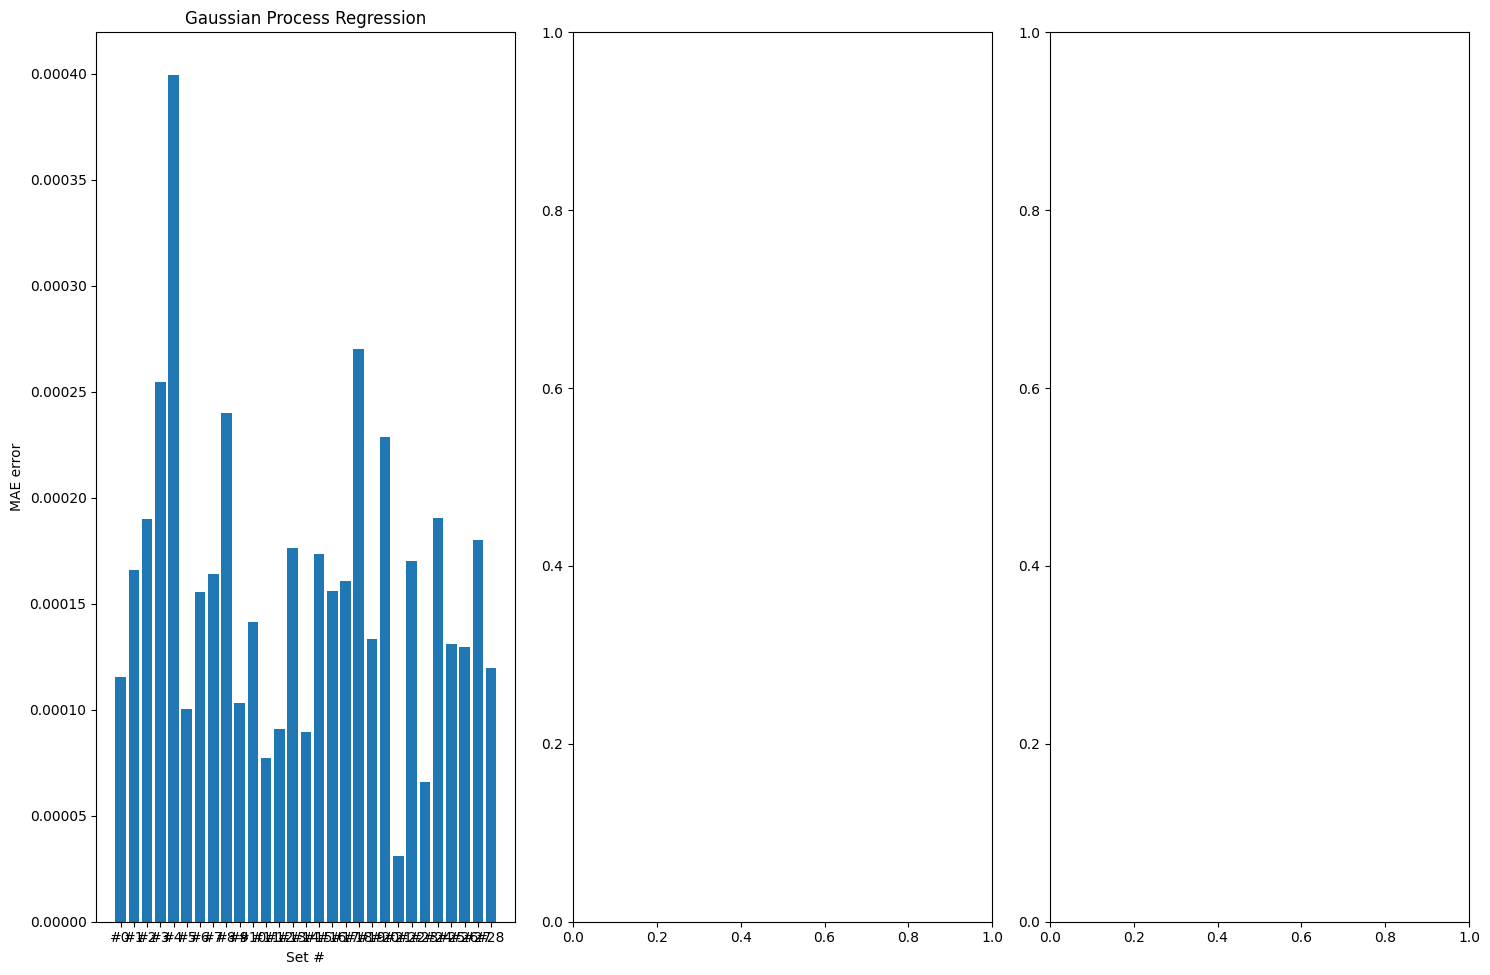

In [22]:
# Set constants
ERR_METHOD = mae

real_bds = np.load('dataset/bounds.npy')
real_trs = np.load('dataset/trans.npy')

set_count = real_trs.shape[0]
res = real_trs.shape[1]
x_test = np.arange(0, res)

fig, axes = plt.subplots(1, 3, figsize=(15, 10))

set_nums = []
err_values = []
for i in range(set_count):
    default_tr = stats.mode(real_trs[i])
    proc_bds, proc_trs = convert_ed(real_bds[i], real_trs[i], res, default_tr)
    pred_trs = gaussian.regression_fit(proc_bds, proc_trs, x_test)
    error = ERR_METHOD(real_trs[i], pred_trs)
    set_nums.append(f'#{i}')
    err_values.append(error)
axes[0].bar(set_nums, err_values)
axes[0].set_xlabel('Set #')
axes[0].set_ylabel(f'{ERR_METHOD.__name__.upper()} error')
axes[0].title.set_text('Gaussian Process Regression')

fig.suptitle(f'')
fig.tight_layout()